# Structure of the notebook

This notebook utilizes the pre-processed taxi trip record data.

The notebook sets the basis for **Chapter 4.1 Temporal Forecasting Models** and **Chapter 5.4 Analysis of Feature Importance:**
<ul>
    <li> Linear Regression (Chapter 4.1.1)</li>
    <li> Random Forest Regression (Chapter 4.1.2)</li>
    <li> Recurrent Neural Network (LSTM) (Chapter 4.1.3)</li>
    <li> Analysis of Feature Importance (Chapter 5.4)</li>
</ul>

# Libraries required to run this notebook

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
! pip install -q openpyxl
import warnings
warnings.filterwarnings("ignore")
import joblib
from joblib import dump
from joblib import load
import cloudpickle

from sklearn.preprocessing import RobustScaler, MinMaxScaler, FunctionTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LinearRegression
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Dropout
from kerastuner.tuners import RandomSearch
import keras_tuner as kt

from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.metrics import RootMeanSquaredError

! pip install -q shap
import shap

2023-06-02 08:36:23.867645: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-02 08:36:29.390283: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-06-02 08:36:41.827794: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-02 08:36:41.828031: W tensorfl

# Data reading and initial exploration

In [3]:
# Read the data
global_feat_data = pd.read_csv("gs://final_prep_data/global_temporal_features.csv")

In [4]:
# Info on the dataset 
global_feat_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4344 entries, 0 to 4343
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   tpep_pickup_datetime  4344 non-null   object 
 1   PU_count              4344 non-null   int64  
 2   PU_month              4344 non-null   int64  
 3   PU_day_of_month       4344 non-null   int64  
 4   PU_day_of_week        4344 non-null   int64  
 5   PU_hour               4344 non-null   int64  
 6   trip_distance         4343 non-null   float64
 7   total_amount          4343 non-null   float64
 8   lag_1h                4344 non-null   float64
 9   lag_2h                4344 non-null   float64
 10  lag_1d                4344 non-null   float64
 11  lag_2d                4344 non-null   float64
 12  ewma_3h               4344 non-null   float64
 13  ewma_6h               4344 non-null   float64
 14  ewma_12h              4344 non-null   float64
 15  ewma_24h             

In [6]:
global_feat_data.head()

,tpep_pickup_datetime,PU_count,PU_month,PU_day_of_month,PU_day_of_week,PU_hour,trip_distance,total_amount,lag_1h,lag_2h,lag_1d,lag_2d,ewma_3h,ewma_6h,ewma_12h,ewma_24h
0,2022-01-01 00:00:00,3507,1,1,5,0,2.757311,18.051933,0.0,0.0,0.0,0.0,3507.000000,3507.000000,3507.000000,3507.000000
1,2022-01-01 01:00:00,4051,1,1,5,1,2.851516,18.022978,3507.0,0.0,0.0,0.0,3869.666667,3824.333333,3801.666667,3790.333333
2,2022-01-01 02:00:00,3100,1,1,5,2,3.046068,18.365532,4051.0,3507.0,0.0,0.0,3429.857143,3498.715596,3527.806005,3540.791209
3,2022-01-01 03:00:00,2211,1,1,5,3,3.256635,18.679724,3100.0,4051.0,0.0,0.0,2779.800000,3001.320946,3112.141810,3165.683113
4,2022-01-01 04:00:00,1321,1,1,5,4,3.652210,19.909424,2211.0,3100.0,0.0,0.0,2026.870968,2411.575208,2625.494982,2732.809394


In [8]:
global_feat_data.tail(len(global_feat_data)-1)[:-1]

,tpep_pickup_datetime,PU_count,PU_month,PU_day_of_month,PU_day_of_week,PU_hour,trip_distance,total_amount,lag_1h,lag_2h,lag_1d,lag_2d,ewma_3h,ewma_6h,ewma_12h,ewma_24h
1,2022-01-01 01:00:00,4051,1,1,5,1,2.851516,18.022978,3507.0,0.0,0.0,0.0,3869.666667,3824.333333,3801.666667,3790.333333
2,2022-01-01 02:00:00,3100,1,1,5,2,3.046068,18.365532,4051.0,3507.0,0.0,0.0,3429.857143,3498.715596,3527.806005,3540.791209
3,2022-01-01 03:00:00,2211,1,1,5,3,3.256635,18.679724,3100.0,4051.0,0.0,0.0,2779.800000,3001.320946,3112.141810,3165.683113
4,2022-01-01 04:00:00,1321,1,1,5,4,3.652210,19.909424,2211.0,3100.0,0.0,0.0,2026.870968,2411.575208,2625.494982,2732.809394
5,2022-01-01 05:00:00,601,1,1,5,5,4.515624,22.438236,1321.0,2211.0,0.0,0.0,1302.619048,1815.042284,2133.436193,2299.564333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4338,2022-06-30 18:00:00,6645,6,30,3,18,2.355977,18.268290,5928.0,5308.0,6886.0,7428.0,6143.583066,5724.549282,5058.373203,4477.559102
4339,2022-06-30 19:00:00,6095,6,30,3,19,2.446198,17.807930,6645.0,5928.0,6414.0,6315.0,6119.291533,5830.392345,5217.854249,4606.954374
4340,2022-06-30 20:00:00,4972,6,30,3,20,2.489914,17.327742,6095.0,6645.0,5513.0,5346.0,5545.645766,5585.137389,5180.030518,4636.158024
4341,2022-06-30 21:00:00,5177,6,30,3,21,2.577813,17.464085,4972.0,6095.0,5470.0,5209.0,5361.322883,5468.526706,5179.564285,4679.425382


In [4]:
# Drop the column 'tpep_pickup_datetime'
# Datetime information is now available in seperate columns (PU_month, PU_day_of_month, PU_hour)
global_feat_data = global_feat_data.drop(['tpep_pickup_datetime'], axis = 1)

In [5]:
# Experiment on multicorrelated feature removal
global_feat_data = global_feat_data.drop(['total_amount','ewma_24h', 'lag_2d'], axis = 1)
# global_feat_data = global_feat_data.drop(['tpep_pickup_datetime','PU_month', 'total_amount', 'frost', 'ewma_12h', 'ewma_24h'], axis = 1)
# global_feat_data = global_feat_data.drop(['tpep_pickup_datetime','PU_month', 'total_amount', 'frost', 'ewma_6h','ewma_12h', 'ewma_24h'], axis = 1)
# global_feat_data = global_feat_data.drop(['tpep_pickup_datetime','PU_month', 'total_amount', 'frost', 'lag_2_days'], axis = 1)
# global_feat_data = global_feat_data.drop(['tpep_pickup_datetime','PU_month', 'total_amount', 'frost', 'lad_2_hours', 'lag_2_days'], axis = 1)

It was observed that removing multicorrelated features such as *total_amount*, *ewma_24h*, and *lag_2d* led to the best predictive results for the linear regression model. Consequently, these columns will be excluded from the dataset and will not be utilized for the temporal forecasting models.

In [6]:
# Final check for missing values
global_feat_data.isna().sum()
global_feat_data.fillna(0, inplace = True)

# Split the data in training and test set

In [7]:
# Seperate explanatory features and target variable
# Definition of explanatory features
X = ['PU_month', 'PU_day_of_month', 'PU_day_of_week', 'PU_hour','trip_distance', 'lag_1h', 'lag_2h', 'lag_1d', 'ewma_3h', 'ewma_6h', 'ewma_12h']

# Definition of the target variable
y = 'PU_count'

In [8]:
# Initialize split ratio: 80% train and 20% test
train_pct = 0.8
test_pct = 0.2

In [9]:
# Split the data into training and test set
n = len(global_feat_data)
train_idx = int(train_pct * n)
train_data = global_feat_data.iloc[:train_idx]
test_data = global_feat_data.iloc[train_idx:]

# Training and test sets for the explanatory variables and response variable
X_train = train_data[X]
y_train = train_data[y]
X_test  = test_data[X]
y_test = test_data[y]

# Print the shapes of the train and test set
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3475, 11) (3475,) (869, 11) (869,)


# Temporal forecasting models

## Linear regression

In [10]:
# Create a copy of the 'X_train' and 'X_test' set because different pre-processing methods will be applied to the explanatory features in each temporal forecasting model
X_train_lr = X_train.copy()
X_test_lr = X_test.copy()
y_train_lr = y_train.copy()
y_test_lr = y_test.copy()

In [11]:
# Definition of transformer functions for sine and cosine transformation on categorical/cyclic data
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))
def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [12]:
# Definition of the column transformer
# Categorical/cyclic features are transformed using sine and cosine transformers
# Numerical features are scaled using RobustScaler()
cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ("PU_month_sin", sin_transformer(6), ["PU_month"]),
        ("PU_month_cos", cos_transformer(6), ["PU_month"]),
        ("PU_day_of_month_sin", sin_transformer(31), ["PU_day_of_month"]),
        ("PU_day_of_month_cos", cos_transformer(31), ["PU_day_of_month"]),
        ("PU_day_of_week_sin", sin_transformer(7), ["PU_day_of_week"]),
        ("PU_day_of_week_cos", cos_transformer(7), ["PU_day_of_week"]),
        ("PU_hour_sin", sin_transformer(24), ["PU_hour"]),
        ("PU_hour_cos", cos_transformer(24), ["PU_hour"]),
    ],
    remainder= RobustScaler(),
)

# Definition of column pipeline to pre-process the input data and define a linear regression component for modeling and prediction
cyclic_cossin_linear_pipeline = make_pipeline(
cyclic_cossin_transformer,
LinearRegression(),
)

### Model training and performance evaluation

In [13]:
# Fit the pipeline on the train set
cyclic_cossin_linear_pipeline.fit(X_train_lr, y_train_lr)

# Predictions for the train set 
y_pred_train_lr = cyclic_cossin_linear_pipeline.predict(X_train_lr)
mae_train_lr = mean_absolute_error(y_train_lr, y_pred_train_lr)
rmse_train_lr = np.sqrt(mean_squared_error(y_train_lr, y_pred_train_lr))

# Predictions for the test set
y_pred_test_lr = cyclic_cossin_linear_pipeline.predict(X_test_lr)
mae_test_lr = mean_absolute_error(y_test_lr, y_pred_test_lr)
rmse_test_lr = np.sqrt(mean_squared_error(y_test_lr, y_pred_test_lr))

# Print the RMSE and MAE for the train set
print("Train set:")
print(f"RMSE: {rmse_train_lr:.2f}")
print(f"MAE: {mae_train_lr:.2f}")

# Print the RMSE and MAE for the test set
print("Test set:")
print(f"RMSE: {rmse_test_lr:.2f}")
print(f"MAE: {mae_test_lr:.2f}")#

Train set:
RMSE: 53.51
MAE: 28.79
Test set:
RMSE: 38.04
MAE: 29.09


### Visualization of performance results

In [14]:
# A dataframe of the actual versus predicted values for the test set is created

# Copy of the X_test_lr data
X_test_lr_datetime = X_test_lr.copy()

# Combine the month, day of month, and hour columns to create a new datetime column
X_test_lr_datetime['datetime'] = pd.to_datetime(dict(year=2022, month=X_test_lr['PU_month'], day=X_test_lr['PU_day_of_month'], hour=X_test_lr['PU_hour']))

# Set the datetime column as the index
X_test_lr_datetime.set_index('datetime', inplace=True)

# Drop the original  'PU_month','PU_day_of_month', and 'PU_hour' columns because this information is now available in the 'datetime' column
X_test_lr_datetime.drop(['PU_month', 'PU_day_of_month', 'PU_hour'], axis=1, inplace=True)

# Convert the response variable of the test data to a numpy array
y_test_array = y_test.to_numpy()

# Round predicted values to integers
y_pred_test_lr_rounded = y_pred_test_lr.round().astype(int)

# Create a dataframe of the actual and predicted values
results_lr = pd.DataFrame({'Actual': y_test_array, 'Predicted': y_pred_test_lr_rounded}, index=X_test_lr_datetime.index)

# Calculate the difference between actual and predicted values and store them in a new column
results_lr['Difference'] = results_lr['Actual'] - results_lr['Predicted']
results_lr

,Actual,Predicted,Difference
datetime,,,
2022-05-25 19:00:00,6837,6819,18
2022-05-25 20:00:00,6046,6018,28
2022-05-25 21:00:00,5893,5904,-11
2022-05-25 22:00:00,4929,5001,-72
2022-05-25 23:00:00,3829,3846,-17
...,...,...,...
2022-06-30 19:00:00,6095,6085,10
2022-06-30 20:00:00,4972,4958,14
2022-06-30 21:00:00,5177,5181,-4


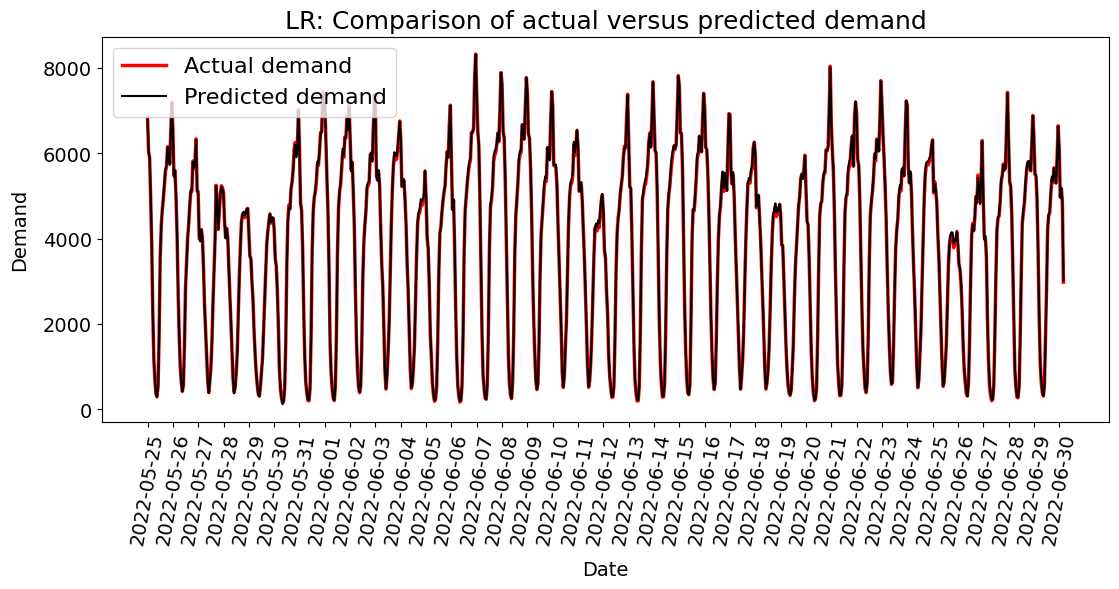

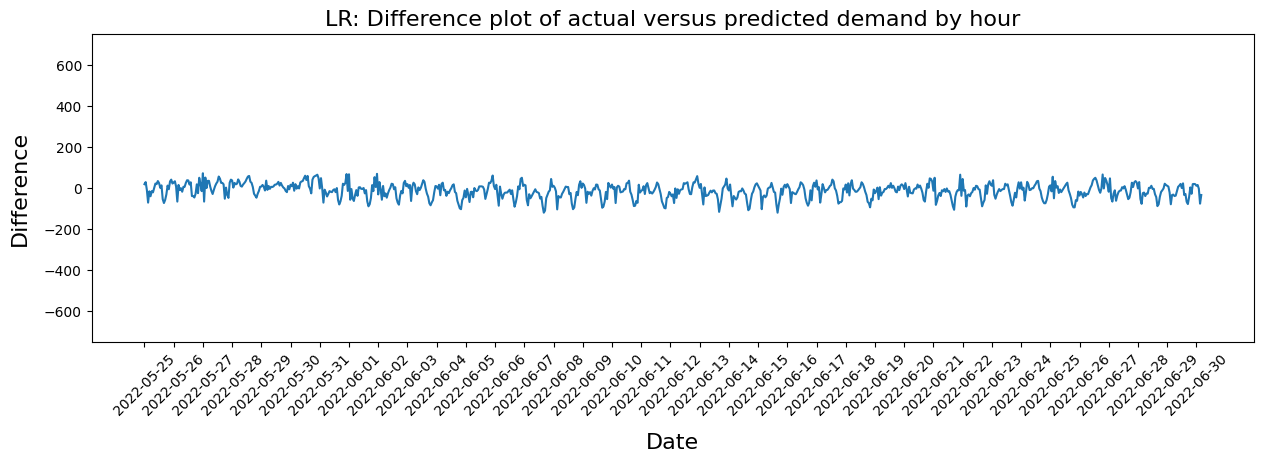

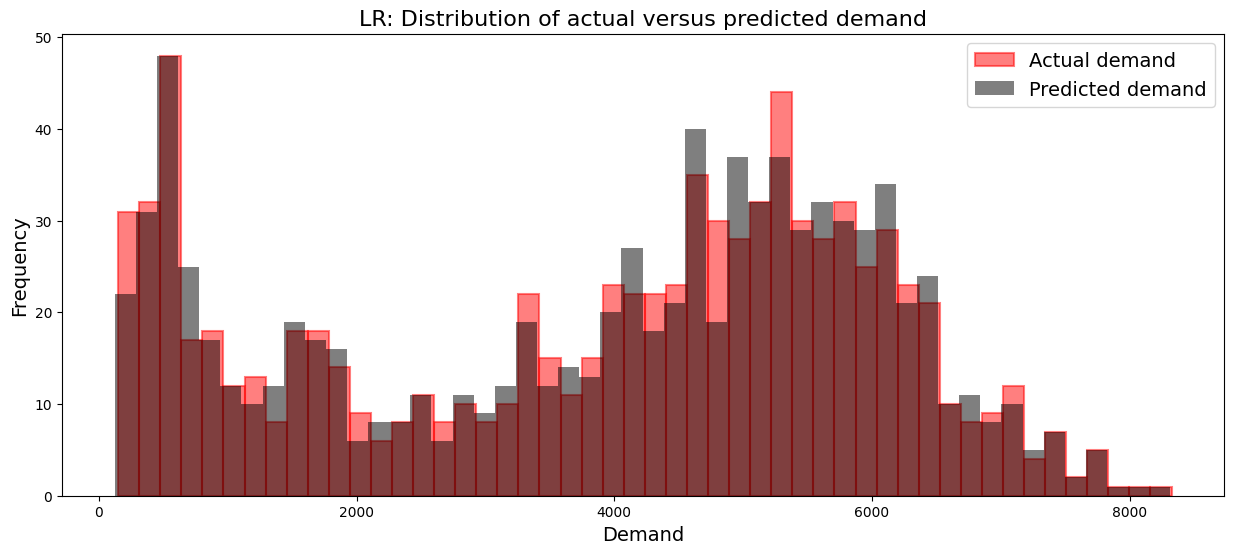

In [16]:
# Time series plot of the actual versus predicted values for the test set
plt.figure(figsize=(13,5))
plt.plot(results_lr.index, results_lr['Actual'], label='Actual demand', color = 'red', linewidth = 2.5)
plt.plot(results_lr.index, results_lr['Predicted'], label='Predicted demand', color = 'black')
plt.xlabel('Date', fontsize = 14, labelpad = 10)
plt.xticks(results_lr.index[::24], results_lr.index.date[::24], rotation= 80, fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Demand', fontsize = 14, labelpad = 10)
plt.title('LR: Comparison of actual versus predicted demand', fontsize = 18)
plt.legend(fontsize = 16)
plt.savefig('LR_actual_predicted.png', bbox_inches = 'tight')
plt.show()

# Difference plot of actual and predicted values for the test set
plt.figure(figsize=(15,4))
plt.plot(results_lr.index, results_lr['Difference'])
plt.xlabel('Date', fontsize = 16, labelpad = 10)
plt.xticks(results_lr.index[::24], results_lr.index.date[::24], rotation=45)
plt.ylim([-750, 750])  # Set y-axis limits
plt.ylabel('Difference', fontsize = 16, labelpad = 10)
plt.title('LR: Difference plot of actual versus predicted demand by hour', fontsize = 16)
plt.show()

# Distribution plot of actual and predicted values for the test set
plt.figure(figsize=(15,6))
plt.hist(results_lr['Actual'], bins=50, alpha=0.5, label='Actual demand', color = 'red', edgecolor='red', linewidth=1.5)
plt.hist(results_lr['Predicted'], bins=50, alpha=0.5, label='Predicted demand', color = 'black')
plt.xlabel('Demand', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('LR: Distribution of actual versus predicted demand', fontsize = 16)
plt.legend(fontsize = 14)
plt.savefig('LR_distribution_actual_predicted.png', bbox_inches = 'tight')
plt.show()

### Analysis of Feature Importance using SHAP values

**Note: The SHAP values have been saved and can be loaded in the subsequent code section due to significant runtime.**

In [17]:
# Create a function that takes a set of inputs and returns the model predictions
model_func = lambda x: cyclic_cossin_linear_pipeline.predict(x)

# Create an explainer object
explainer_lr = shap.Explainer(model_func, X_train, n_jobs = -1)

# Compute SHAP values for the test data
shap_values = explainer_lr(X_test)

# Save the SHAP values
with open("shap_values_lr.joblib", "wb") as f:
    cloudpickle.dump(shap_values, f)

Permutation explainer: 870it [06:22,  2.21it/s]                         


In [14]:
# Load the SHAP values
with open("shap_values_lr.joblib", "rb") as f:
    shap_values = joblib.load(f)

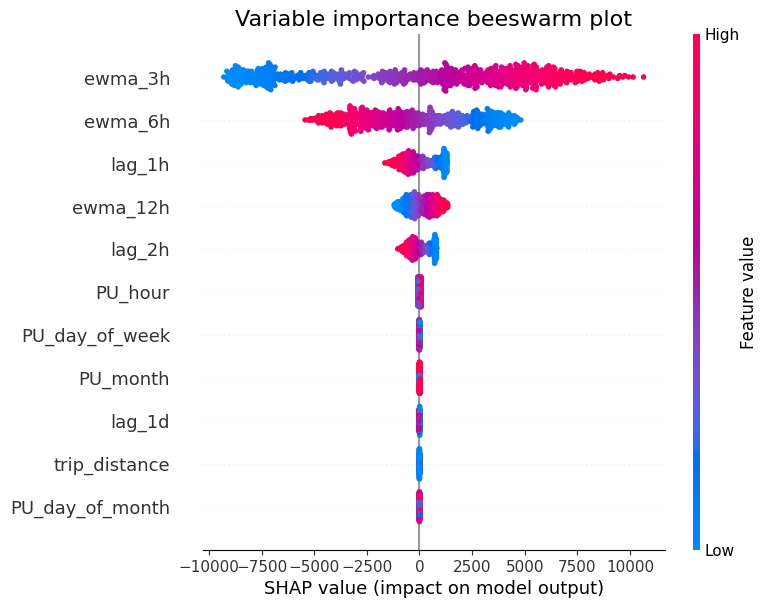

In [15]:
# Visualize the SHAP values using a swarm plot
shap.summary_plot(shap_values, X_test, plot_size=(8, 6), show = False)
plt.title('Variable importance beeswarm plot', fontsize = 16)
plt.savefig('Swarmplot_LR', bbox_inches = 'tight')

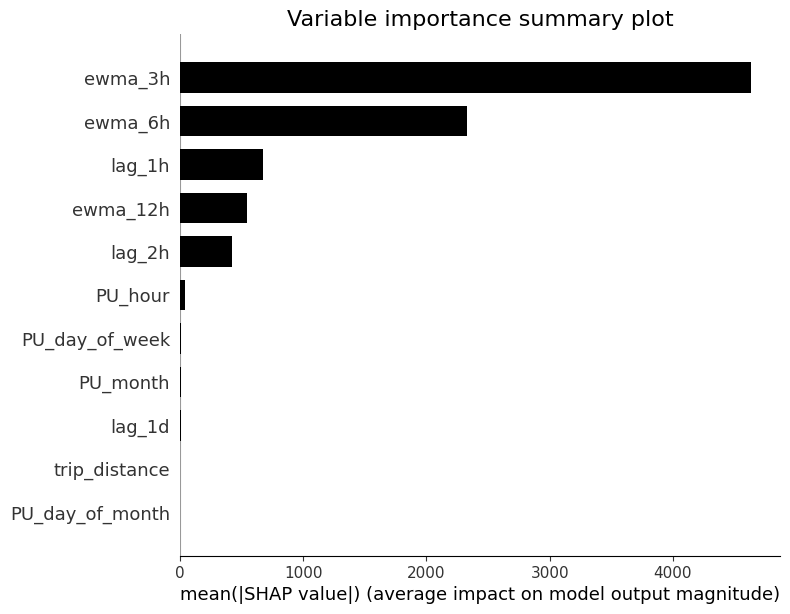

In [16]:
# Visualize the SHAP values using a summary plot
shap.summary_plot(shap_values, X_test, plot_type = "bar", color = 'black', plot_size = (8,6), show = False)
plt.title('Variable importance summary plot', fontsize = 16)
plt.savefig('Summaryplot_LR', bbox_inches = 'tight')

## Random forest

In [17]:
# Specification of categorical features
categorical_features = ['PU_hour']

# Option 2 tested: categorical_features = ['PU_day_of_month', 'PU_day_of_week', 'PU_hour']

In [18]:
# Initialize an instance of the One-Hot-Encoder to pre-process the categorical features
one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse = False)

In [19]:
# Create copies of the train and test data
X_train_rf = X_train.copy()
X_test_rf = X_test.copy()

In [20]:
# Create a pipeline for random forest regression 
# Column Transformer is used to one-hot-encode 'PU_hour'
rf_pipeline = make_pipeline(
    # The ColumnTransformer component allows for different transformations to be applied to different subsets of the input data
    ColumnTransformer(
        # Tuple specifying the name of the name of the transformation, and the transformer object to be applied on the categorical features
        transformers=[
        ("categorical", one_hot_encoder, categorical_features),
        ],
        # The remaining columns are not further transformed
        remainder= "passthrough",
    ),
    # Initialize Random Forest Regression
    RandomForestRegressor(n_jobs = -1)
)

## Build a tuned random forest model

**Note: The code snippet below can be skipped, and the model along with the tuned hyperparameter results can be loaded in the subsequent section "Performance evaluation of the tuned random forest model".**

In [54]:
# Define hyperparameter search space
param_distributions = {
    "randomforestregressor__n_estimators":  [int (x) for x in np.linspace(start = 100, stop = 1000, num= 10)] , # Determine the number of trees (list of integer values ranging from 100 to 1000, with 10 evenly spaced values)
    "randomforestregressor__max_depth": [3,4,5,10,30,50,80,100], # Determine the maximum depth of each tree from the list of pre-defined values
    "randomforestregressor__min_samples_split": [2,4,6,8,10], # Determine the number of samples required to split an internal node from a list of pre-defined values
    "randomforestregressor__min_samples_leaf": [1,2,4,5,8,10], # Determine the number of samples required to be at a leaf node from a list of pre-defined values
    "randomforestregressor__max_features": ["auto", "sqrt", "log2"], # Determine the number of features to consider when looking for the best split
}

# Number of parameter settings that are sampled
n_iter = 100

# Perform random search with cross-validation
random_search = RandomizedSearchCV(
    rf_pipeline, param_distributions, n_iter=n_iter, verbose=1, n_jobs=-1, cv = 2
)
random_search.fit(X_train_rf, y_train)

# Print the best hyparameters and score
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

# Save the best model
best_random_forest = random_search.best_estimator_
dump(best_random_forest, 'best_random_forest.joblib')

Fitting 2 folds for each of 100 candidates, totalling 200 fits
Best Parameters:  {'randomforestregressor__n_estimators': 900, 'randomforestregressor__min_samples_split': 2, 'randomforestregressor__min_samples_leaf': 1, 'randomforestregressor__max_features': 'auto', 'randomforestregressor__max_depth': 100}
Best Score:  0.977855049369899


['best_random_forest.joblib']

### Performance evaluation of the tuned random forest model

In [21]:
# Load the saved model
best_random_forest = load('best_random_forest.joblib')

In [22]:
# Create predictions for the train set
y_pred_train_rf = best_random_forest.predict(X_train_rf)

# Calculate RMSE and MAE for the train set
rmse_train_rf = np.sqrt(mean_squared_error(y_train, y_pred_train_rf))
mae_train_rf = mean_absolute_error(y_train, y_pred_train_rf)

# Print the RMSE and MAE for the train set
print("Train set:")
print(f"RMSE: {rmse_train_rf:.2f}")
print(f"MAE: {mae_train_rf:.2f}")

# Create predictions for the test set
y_pred_test_rf = best_random_forest.predict(X_test_rf)

# Calculate metrics for the test set
mae_test_rf = mean_absolute_error(y_test, y_pred_test_rf)
rmse_test_rf = np.sqrt(mean_squared_error(y_test, y_pred_test_rf))

# Print the RMSE and MAE for the test set
print("Test set:")
print(f"RMSE: {rmse_test_rf:.2f}")
print(f"MAE: {mae_test_rf:.2f}")

Train set:
RMSE: 43.07
MAE: 28.97
Test set:
RMSE: 123.27
MAE: 82.99


### Visualizations of performance results

In [23]:
# A dataframe of the actual versus predicted values for the test set is created: 

# Round predicted values to integers
y_pred_test_rf_rounded = y_pred_test_rf.round().astype(int)

# Create a dataframe of the actual and rounded predicted values
results_rf = pd.DataFrame({'Actual': y_test_array, 'Predicted': y_pred_test_rf_rounded}, index=X_test_lr_datetime.index)

# Calculate the difference between actual and predicted values and store the difference in a new column
results_rf['Difference'] = results_rf['Actual'] - results_rf['Predicted']

# Print the dataframe
results_rf

,Actual,Predicted,Difference
datetime,,,
2022-05-25 19:00:00,6837,6927,-90
2022-05-25 20:00:00,6046,6013,33
2022-05-25 21:00:00,5893,5769,124
2022-05-25 22:00:00,4929,4937,-8
2022-05-25 23:00:00,3829,4087,-258
...,...,...,...
2022-06-30 19:00:00,6095,6025,70
2022-06-30 20:00:00,4972,5047,-75
2022-06-30 21:00:00,5177,4943,234


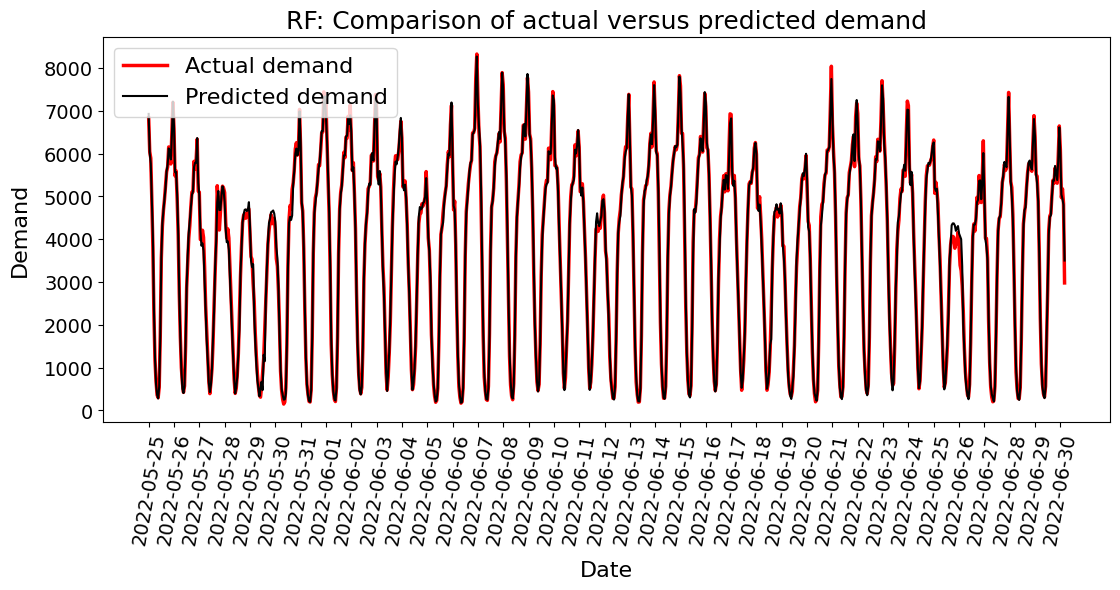

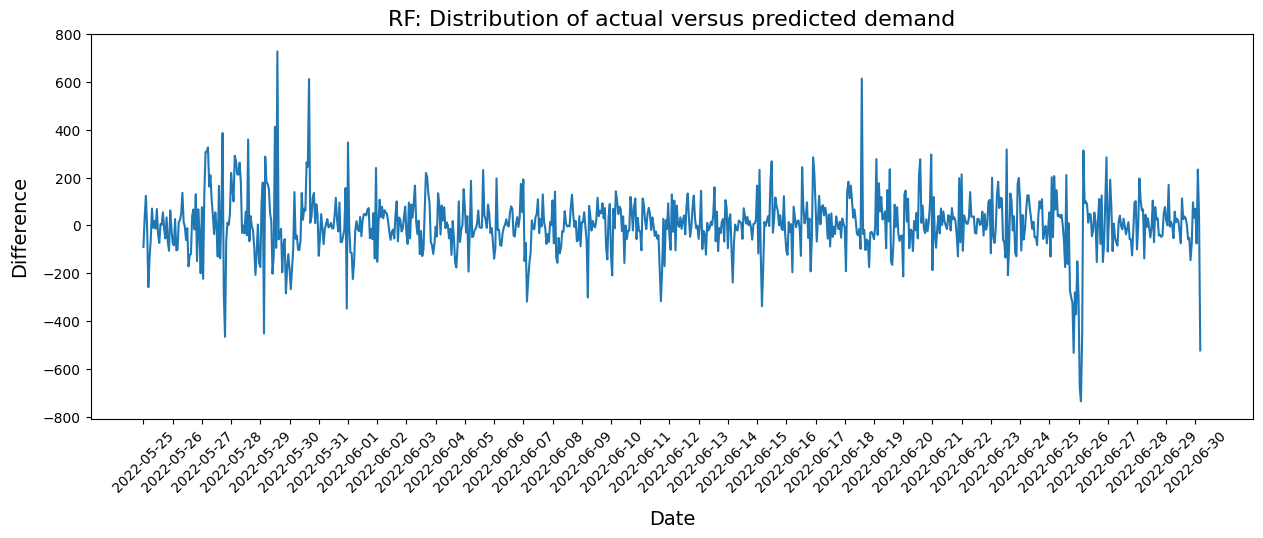

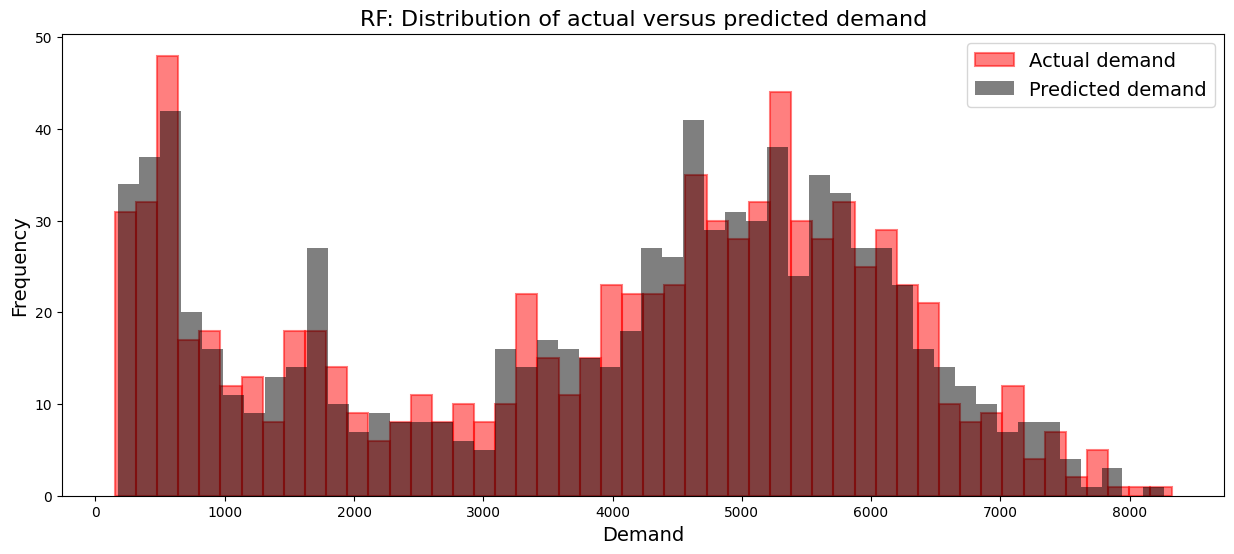

In [24]:
# Time series plot of actual versus predicted results

plt.figure(figsize=(13,5))
plt.plot(results_rf.index, results_rf['Actual'], label='Actual demand', color = 'red', linewidth = 2.5)
plt.plot(results_rf.index, results_rf['Predicted'], label='Predicted demand', color = 'black')
plt.xlabel('Date', fontsize = 16, labelpad = 10)
plt.xticks(results_rf.index[::24], results_rf.index.date[::24], rotation=80, fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylabel('Demand', fontsize = 16, labelpad = 10)
plt.title('RF: Comparison of actual versus predicted demand', fontsize = 18)
plt.legend(fontsize = 16)
plt.savefig('RF_actual_predicted.png', bbox_inches = 'tight')
plt.show()

# Difference plot of actual versus predicted values

plt.figure(figsize=(15,5))
plt.plot(results_rf.index, results_rf['Difference'])
plt.xlabel('Date', fontsize = 14, labelpad = 10)
plt.xticks(results_rf.index[::24], results_rf.index.date[::24], rotation=45)
plt.ylabel('Difference', fontsize = 14, labelpad = 10)
plt.title('RF: Distribution of actual versus predicted demand', fontsize = 16)
plt.show()

# Distribution plot of actual and predicted values

plt.figure(figsize=(15,6))
plt.hist(results_rf['Actual'], bins=50, alpha=0.5, label='Actual demand', color = 'red', edgecolor = 'red', linewidth = 1.5)
plt.hist(results_rf['Predicted'], bins=50, alpha=0.5, label='Predicted demand', color = 'black')
plt.xlabel('Demand', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('RF: Distribution of actual versus predicted demand', fontsize = 16)
plt.legend(fontsize = 14)
plt.savefig('RF_distribution_actual_predicted.png', bbox_inches = 'tight')
plt.show()

## Long Short-Term Memory (LSTM)

### Set-up the data for the univariate LSTM

The deployed LSTM differs from the Linear Regression and Random Forest model because it does not utilize explanatory variables. Initially, it was attempted to create a multivariate LSTM. However, the results displayed an array of NaNs. This is likely because the features represent autoregressive and rolling statistics features of the dependent variable. This information may be already captured from the memory of the LSTM.

In [2]:
# Read the data for a fresh start
global_feat_data_lstm = pd.read_csv("gs://final_prep_data/global_temporal_features.csv")

# Convert the 'tpep_pickup_datetime' column to datetime format
global_feat_data_lstm['tpep_pickup_datetime'] = pd.to_datetime(global_feat_data_lstm['tpep_pickup_datetime'])

# Drop all explanatory features from the dataframe
global_feat_data_lstm.drop(['PU_month', 'PU_day_of_month','PU_day_of_week', 'PU_hour', 'trip_distance', 'total_amount','lag_1h', 'lag_2h', 'lag_1d', 'lag_2d', 'ewma_3h','ewma_6h', 'ewma_12h', 'ewma_24h'], axis = 1, inplace = True)

# Set the column 'tpep_pickup_datetime' as index of the dataframe
data = global_feat_data_lstm.set_index('tpep_pickup_datetime')

# Display the first five rows of the dataframe
data.head()

,PU_count
tpep_pickup_datetime,
2022-01-01 00:00:00,3507
2022-01-01 01:00:00,4051
2022-01-01 02:00:00,3100
2022-01-01 03:00:00,2211
2022-01-01 04:00:00,1321


### Split the data into training and test set

In [3]:
# Split the data in 80 % train and 20 % test data
train_size = int(len(data) * 0.8)
train_data, test_data = data[:train_size], data[train_size:]

# Print the shape of the train and test dataset
print(train_data.shape, test_data.shape)

(3475, 1) (869, 1)


### Scale the data and seperate explanatory features and target variable

In [4]:
# The 'PU_count' column is scaled using RobustScaler
# Initialize the RobustScaler instance 
scaler = RobustScaler()

# Fit the RobustScaler instance to the training data using the fit() method
train_scaled = scaler.fit_transform(train_data)

# Use the trained instance to transform the test data
test_scaled = scaler.transform(test_data)

# Split the data into input (X) and output (y) variables
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:i + time_steps, :]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Define the number of time steps to consider for each input sequence
time_steps = 24

# Create input-output pairs for the training data
X_train, y_train = create_dataset(train_scaled, train_scaled[:, 0], time_steps)

# Create input-output pairs for the test data
X_test, y_test = create_dataset(test_scaled, test_scaled[:, 0], time_steps)

# Print the shape of the created input-output pairs
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(3451, 24, 1) (3451,) (845, 24, 1) (845,)


## Build a tuned LSTM model using keras

**Note: The code snippet below can be skipped and the model along with the tuned hyperparameter results can be loaded in the subsequent section "Performance evaluation of the tuned LSTM model".**

In [32]:
# Define a function named 'build_model' that constructs a LSTM 
def build_model(hp):
    # Build the sequential LSTM model, which allows us to build the model by adding layers one after another
    model = Sequential()
    
    # Loop to add LSTM layers with different configurations
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(LSTM(units=hp.Int('units_' + str(i), 10, 300, step=10), # Determine the number of units in each LSTM (chosen from a range of integers between 10 and 300, with a step size of 10)
                       activation=hp.Choice('activation_' + str(i), values=['tanh', 'relu', 'elu', 'softplus']), # Determine the activation function used in each layer (tanh, relu, elu and softplus)
                       return_sequences=(i < hp.Int('num_layers', 1, 4) - 1), # Determine the number of layers (integer between 1 and 4)
                       input_shape=(X_train.shape[1], X_train.shape[2]))) 
        model.add(Dropout(hp.Float('dropout_' + str(i), 0.0, 0.5, step=0.1))) # Determine the dropout rate applied after each LSTM to prevent overfitting (chosen from a range of floats between 0.0 and 0.5, with a step size of 0.1)
    
    # Add dense layer for the output
    model.add(Dense(units=1))
    
    # Compile the model using the Adam optimizer, loss function and evaluation metrics
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])), # Determine the learning rate of the Adam optimizer (chosen from a set of pre-defined values)
                  loss='mean_squared_error', metrics=['mean_squared_error']) # Determine the loss function and metrics for the model
    
    # Determine the batch size used during training (chosen from a set of pre-defined values)
    batch_size = hp.Choice('batch_size', values=[16, 18, 20, 22, 24, 26, 28])
    return model

In [33]:
# Set the tuner object using an instance of the RandomSearch class

tuner = RandomSearch(
    build_model, # function that defines the model architecture and hyperparameter space (previously specified)
    objective='val_mean_squared_error', # Metric to optimize during the hyperparameter search
    max_trials=10, # Maximum number of hyperparameter combination to try 
    executions_per_trial=3, # Number of times to train and evaluate each model configuration
    directory='tuned_lstm_dir', # Directory with search results and checkpoints
    project_name='tuned_lstm_proj') # Name of the project

INFO:tensorflow:Reloading Tuner from tuned_lstm_dir/tuned_lstm_proj/tuner0.json


In [33]:
# Start the hyperparameter search process 

tuner.search(X_train, 
             y_train, 
             epochs=25, # Number of epochs to train each model configuration
             validation_split=0.1, # Fraction of training data to be used for validation
             shuffle=False) # The data is not shuffled because it is a time series

Trial 10 Complete [00h 07m 44s]
val_mean_squared_error: 0.006213583673040072

Best val_mean_squared_error So Far: 0.0055679612172146635
Total elapsed time: 01h 14m 58s
INFO:tensorflow:Oracle triggered exit


In [34]:
# Retrieve the best hyperparameters found during hyperparameter search
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Number of LSTM layers: ", best_hps.get('num_layers'))
for i in range(best_hps.get('num_layers')):
    print("Units in LSTM layer", i+1, ": ", best_hps.get('units_'+str(i)))
    print("Activation function in LSTM layer", i+1, ": ", best_hps.get('activation_'+str(i)))
    print("Dropout in LSTM layer", i+1, ": ", best_hps.get('dropout_'+str(i)))
print("Learning rate: ", best_hps.get('learning_rate'))
print("Batch size: ", best_hps.get('batch_size'))

Number of LSTM layers:  1
Units in LSTM layer 1 :  60
Activation function in LSTM layer 1 :  elu
Dropout in LSTM layer 1 :  0.30000000000000004
Learning rate:  0.01
Batch size:  24


In [35]:
# Create the model using the best hyperparameters obtained from the hyperparameter search
model_lstm_tuned = build_model(best_hps)

# Train the model
# The training history is stored in 'history_lstm_tuned'
history_lstm_tuned = model_lstm_tuned.fit(X_train, y_train,epochs = 25, validation_split=0.1, shuffle=False)

Epoch 1/25
98/98 [==============================] - 3s 16ms/step - loss: 0.0474 - mean_squared_error: 0.0474 - val_loss: 0.0215 - val_mean_squared_error: 0.0215
Epoch 2/25
98/98 [==============================] - 1s 14ms/step - loss: 0.0225 - mean_squared_error: 0.0225 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 3/25
98/98 [==============================] - 1s 14ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - val_loss: 0.0117 - val_mean_squared_error: 0.0117
Epoch 4/25
98/98 [==============================] - 2s 19ms/step - loss: 0.0166 - mean_squared_error: 0.0166 - val_loss: 0.0102 - val_mean_squared_error: 0.0102
Epoch 5/25
98/98 [==============================] - 2s 16ms/step - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 6/25
98/98 [==============================] - 1s 14ms/step - loss: 0.0131 - mean_squared_error: 0.0131 - val_loss: 0.0074 - val_mean_squared_error: 0.0074
Epoch 7/25
98/98 [================

In [36]:
# Overview of the model's architecture, layer types, output shapes, and number of parameters
model_lstm_tuned.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60)                14880     
                                                                 
 dropout_3 (Dropout)         (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                                 
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


In [37]:
# Save the model
model_lstm_tuned.save('model_lstm_tuned_final.h5')

### Performance evaluation of the tuned LSTM model

In [5]:
# Load the model
model_lstm_tuned_loaded = load_model('model_lstm_tuned_final.h5')

2023-06-02 08:37:36.598676: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-06-02 08:37:36.618796: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2023-06-02 08:37:36.618834: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (85f97a510381): /proc/driver/nvidia/version does not exist
2023-06-02 08:37:36.620132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable 

In [6]:
model_lstm_tuned_loaded.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 60)                14880     
                                                                 
 dropout_3 (Dropout)         (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                                 
Total params: 14,941
Trainable params: 14,941
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Make predictions on training and test data
train_pred_lstm_tuned = model_lstm_tuned_loaded.predict(X_train)
test_pred_lstm_tuned = model_lstm_tuned_loaded.predict(X_test)

27/27 [==============================] - 0s 4ms/step


In [8]:
# Inverse scaling of the predictions and the actual values
# This is required as the dependent variable 'PU_count' was previously scaled using RobustScaler()
train_pred_lstm_tuned_inv = scaler.inverse_transform(np.concatenate((train_pred_lstm_tuned, X_train[:, -1, 0].reshape(-1, 1)), axis=1))[:, 0]
test_pred_lstm_tuned_inv = scaler.inverse_transform(np.concatenate((test_pred_lstm_tuned, X_test[:, -1, 0].reshape(-1, 1)), axis=1))[:, 0]
y_train_inv = scaler.inverse_transform(np.concatenate((y_train.reshape(-1, 1), X_train[:, -1, 0].reshape(-1, 1)), axis=1))[:, 0]
y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), X_test[:, -1, 0].reshape(-1, 1)), axis=1))[:, 0]

# Calculate MAE and RMSE on the train data
train_mae_lstm_tuned_inv = mean_absolute_error(y_train_inv, train_pred_lstm_tuned_inv)
train_rmse_lstm_tuned_inv = np.sqrt(mean_squared_error(y_train_inv, train_pred_lstm_tuned_inv))

# Print the RMSE and MAE for the train set
print("Train set:")
print(f"MAE (inverse scaled): {train_mae_lstm_tuned_inv:.2f}")
print(f"RMSE (inverse scaled): {train_rmse_lstm_tuned_inv:.2f}")

# Calculate MAE and RMSE on the test data
test_mae_lstm_tuned_inv = mean_absolute_error(y_test_inv, test_pred_lstm_tuned_inv)
test_rmse_lstm_tuned_inv = np.sqrt(mean_squared_error(y_test_inv, test_pred_lstm_tuned_inv))

# Print the RMSE and MAE for the test set
print("Test set:")
print(f"MAE (inverse scaled): {test_mae_lstm_tuned_inv:.2f}")
print(f"RMSE (inverse scaled): {test_rmse_lstm_tuned_inv:.2f}")

Train set:
MAE (inverse scaled): 244.97
RMSE (inverse scaled): 317.28
Test set:
MAE (inverse scaled): 239.83
RMSE (inverse scaled): 309.83


### Visualization of performance results

In [9]:
# Round predicted values to integers
test_pred_lstm_tuned_inv= test_pred_lstm_tuned_inv.round().astype(int)

# Create a dataframe of the actual and predicted values for the test set
results_lstm = pd.DataFrame({'Actual': y_test_inv, 'Predicted': test_pred_lstm_tuned_inv}, index=test_data.index[time_steps:])


# Calculate the difference between actual and predicted values
results_lstm['Difference'] = results_lstm['Actual'] - results_lstm['Predicted']

# Print the results
results_lstm

,Actual,Predicted,Difference
tpep_pickup_datetime,,,
2022-05-26 19:00:00,6577.0,6294,283.0
2022-05-26 20:00:00,5480.0,5489,-9.0
2022-05-26 21:00:00,5598.0,5105,493.0
2022-05-26 22:00:00,4944.0,5165,-221.0
2022-05-26 23:00:00,4091.0,3857,234.0
...,...,...,...
2022-06-30 19:00:00,6095.0,5837,258.0
2022-06-30 20:00:00,4972.0,5124,-152.0
2022-06-30 21:00:00,5177.0,4633,544.0


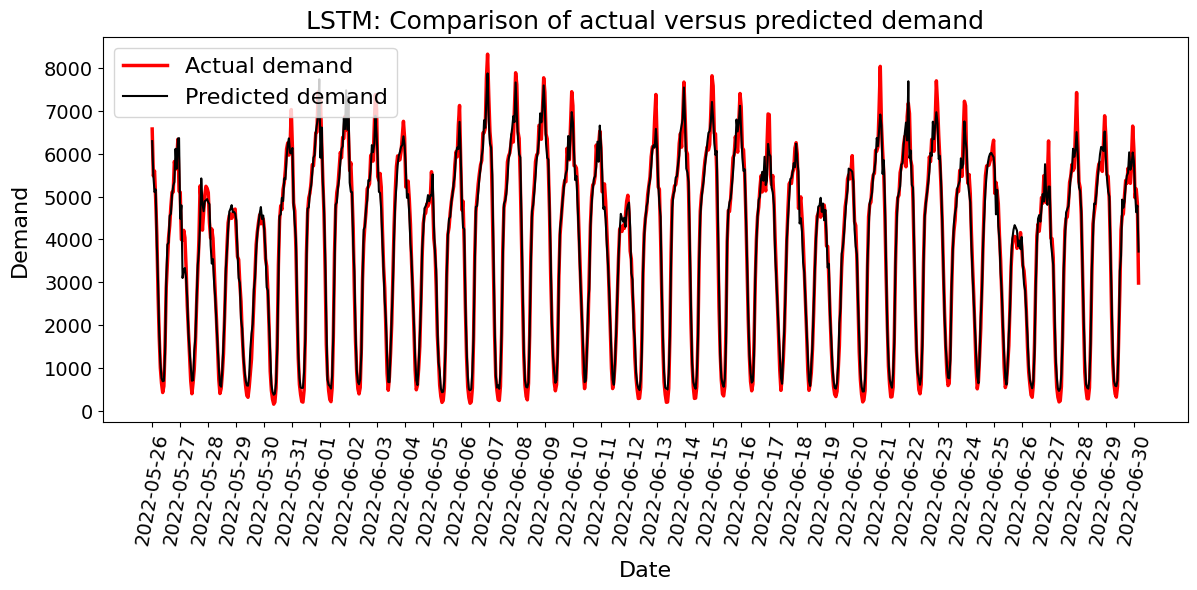

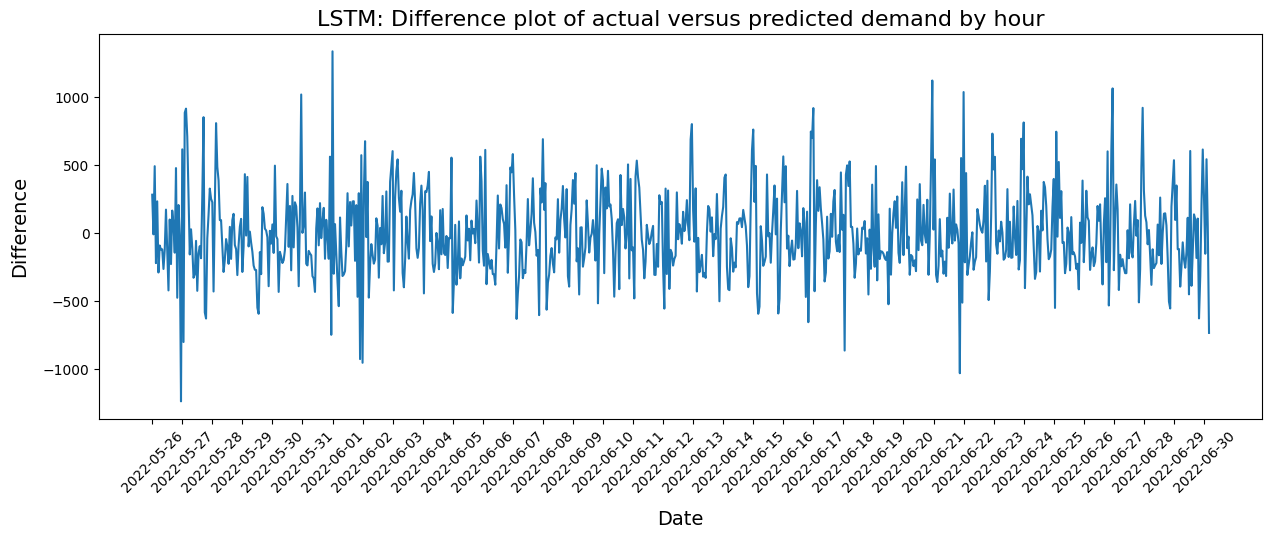

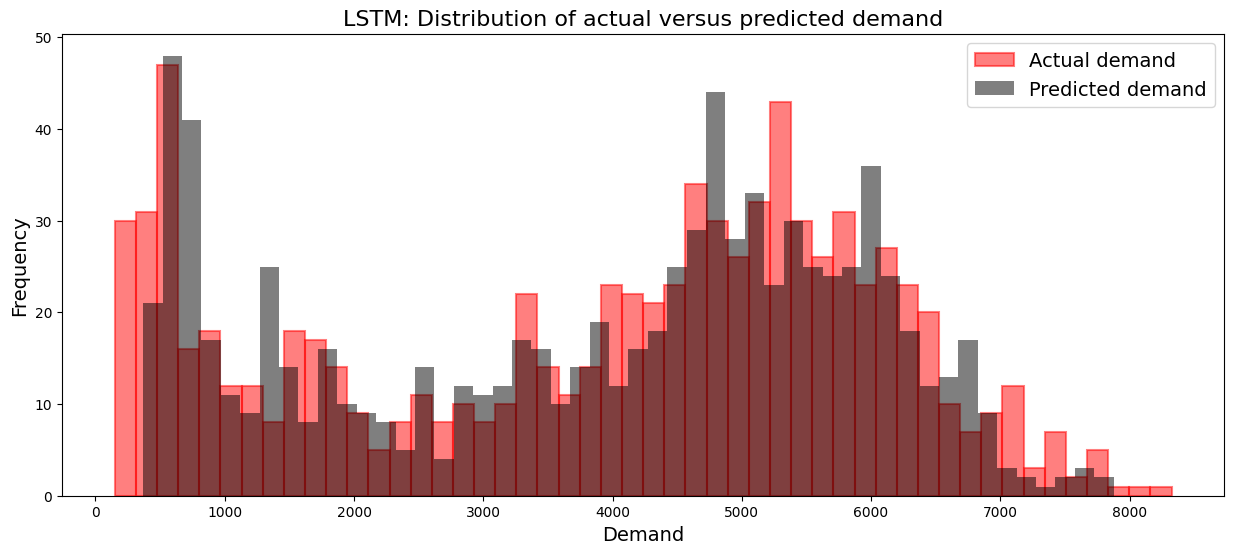

In [10]:
# Time series plot of actual versus predicted values
plt.figure(figsize=(14,5))
plt.plot(results_lstm.index, results_lstm['Actual'], label='Actual demand', color = 'red', linewidth = 2.5 )
plt.plot(results_lstm.index, results_lstm['Predicted'], label='Predicted demand', color = 'black')
plt.xlabel('Date', fontsize = 16, labelpad = 10)
plt.xticks(results_lstm.index[::24], results_lstm.index.date[::24], rotation= 80, fontsize = 14) # Set xticks for every 24 hours (1 day) with  .date
plt.yticks(fontsize = 14)
plt.ylabel('Demand', fontsize = 16, labelpad = 10)
plt.title('LSTM: Comparison of actual versus predicted demand', fontsize = 18)
plt.legend(fontsize = 16, loc='upper left')
plt.savefig('LSTM_actual_predicted.png', bbox_inches = 'tight')
plt.show()

# Difference plot of actual and predicted values
plt.figure(figsize=(15,5))
plt.plot(results_lstm.index, results_lstm['Difference'])
plt.xlabel('Date', fontsize = 14, labelpad = 10)
plt.xticks(results_lstm.index[::24], results_lstm.index.date[::24], rotation=45)
plt.ylabel('Difference', fontsize = 14, labelpad = 10)
plt.title('LSTM: Difference plot of actual versus predicted demand by hour', fontsize = 16)
plt.show()

# Distribution plot of actual and predicted values
plt.figure(figsize=(15,6))
plt.hist(results_lstm['Actual'], bins=50, alpha=0.5, label='Actual demand', color = 'red', edgecolor = 'red', linewidth = 1.5)
plt.hist(results_lstm['Predicted'], bins=50, alpha=0.5, label='Predicted demand', color = 'black')
plt.xlabel('Demand', fontsize = 14)
plt.ylabel('Frequency', fontsize = 14)
plt.title('LSTM: Distribution of actual versus predicted demand', fontsize = 16)
plt.legend(fontsize = 14)
plt.savefig('LSTM_distribution_actual_predicted.png', bbox_inches = 'tight')
plt.show()

# Comparison of the temporal forecasting models

## Create a dataframe for the temporal forecasting model results

In [47]:
# Rename columns to get a better overview ob the individual model's results when combined in one dataframe
results_lr.rename(columns = {'Predicted': 'Predicted_LR',
                            'Difference': 'Difference_LR'}, inplace = True)
results_rf.rename(columns = {'Predicted' : 'Predicted_RF',
                            'Difference' : 'Difference_RF'}, inplace = True)
results_lstm.rename(columns = {'Predicted': 'Predicted_LSTM',
                              'Difference': 'Difference_LSTM'}, inplace = True)

In [48]:
# Merge the dataframes results_lr, results_rf, and results_lstm based on their datetime indices
results_all_models = pd.merge(pd.merge(results_lr,results_rf,left_index = True, right_index = True),results_lstm,left_index = True, right_index = True)

# Drop unnecessary columns and rename the column that displays the actual values
results_all_models.drop(['Actual_y', 'Actual'], inplace = True, axis = 1)
results_all_models.rename(columns = {'Actual_x': 'Actual'}, inplace = True)

# Print the merged dataframe
print(results_all_models)

                     Actual  Predicted_LR  Difference_LR  Predicted_RF  \
2022-05-26 19:00:00    6577          6551             26          6651   
2022-05-26 20:00:00    5480          5448             32          5563   
2022-05-26 21:00:00    5598          5592              6          5571   
2022-05-26 22:00:00    4944          5011            -67          5048   
2022-05-26 23:00:00    4091          4077             14          4192   
...                     ...           ...            ...           ...   
2022-06-30 19:00:00    6095          6085             10          6025   
2022-06-30 20:00:00    4972          4958             14          5047   
2022-06-30 21:00:00    5177          5181             -4          4943   
2022-06-30 22:00:00    4839          4916            -77          4800   
2022-06-30 23:00:00    2979          3014            -35          3502   

                     Difference_RF  Predicted_LSTM  Difference_LSTM  
2022-05-26 19:00:00            -74       

The comparison of predictive results will only be displayed for the last 24 hours of the test data.

In [49]:
# Set the end datetime as the last predicted datetime in the test set
end_datetime = results_all_models.index[-2]

# Set the start datetime as 24 hours before the end datetime
start_datetime = end_datetime - pd.Timedelta(hours=24)

# Filter the results for the desired time span
results_24h_all_models = results_all_models[(results_all_models.index >= start_datetime) & (results_all_models.index <= end_datetime)]
results_24h_all_models

,Actual,Predicted_LR,Difference_LR,Predicted_RF,Difference_RF,Predicted_LSTM,Difference_LSTM
2022-06-29 22:00:00,4883,4963,-80,4888,-5,5002,-119.0
2022-06-29 23:00:00,3681,3716,-35,3665,16,3798,-117.0
2022-06-30 00:00:00,2164,2197,-33,2166,-2,2558,-394.0
2022-06-30 01:00:00,1086,1126,-40,1139,-53,1333,-247.0
2022-06-30 02:00:00,617,655,-38,559,58,685,-68.0
2022-06-30 03:00:00,388,405,-17,375,13,581,-193.0
2022-06-30 04:00:00,314,309,5,286,28,569,-255.0
2022-06-30 05:00:00,566,555,11,548,18,706,-140.0
2022-06-30 06:00:00,1644,1625,19,1668,-24,1531,113.0
2022-06-30 07:00:00,2811,2812,-1,2885,-74,3262,-451.0


## Visualization of the results of the temporal forecasting models

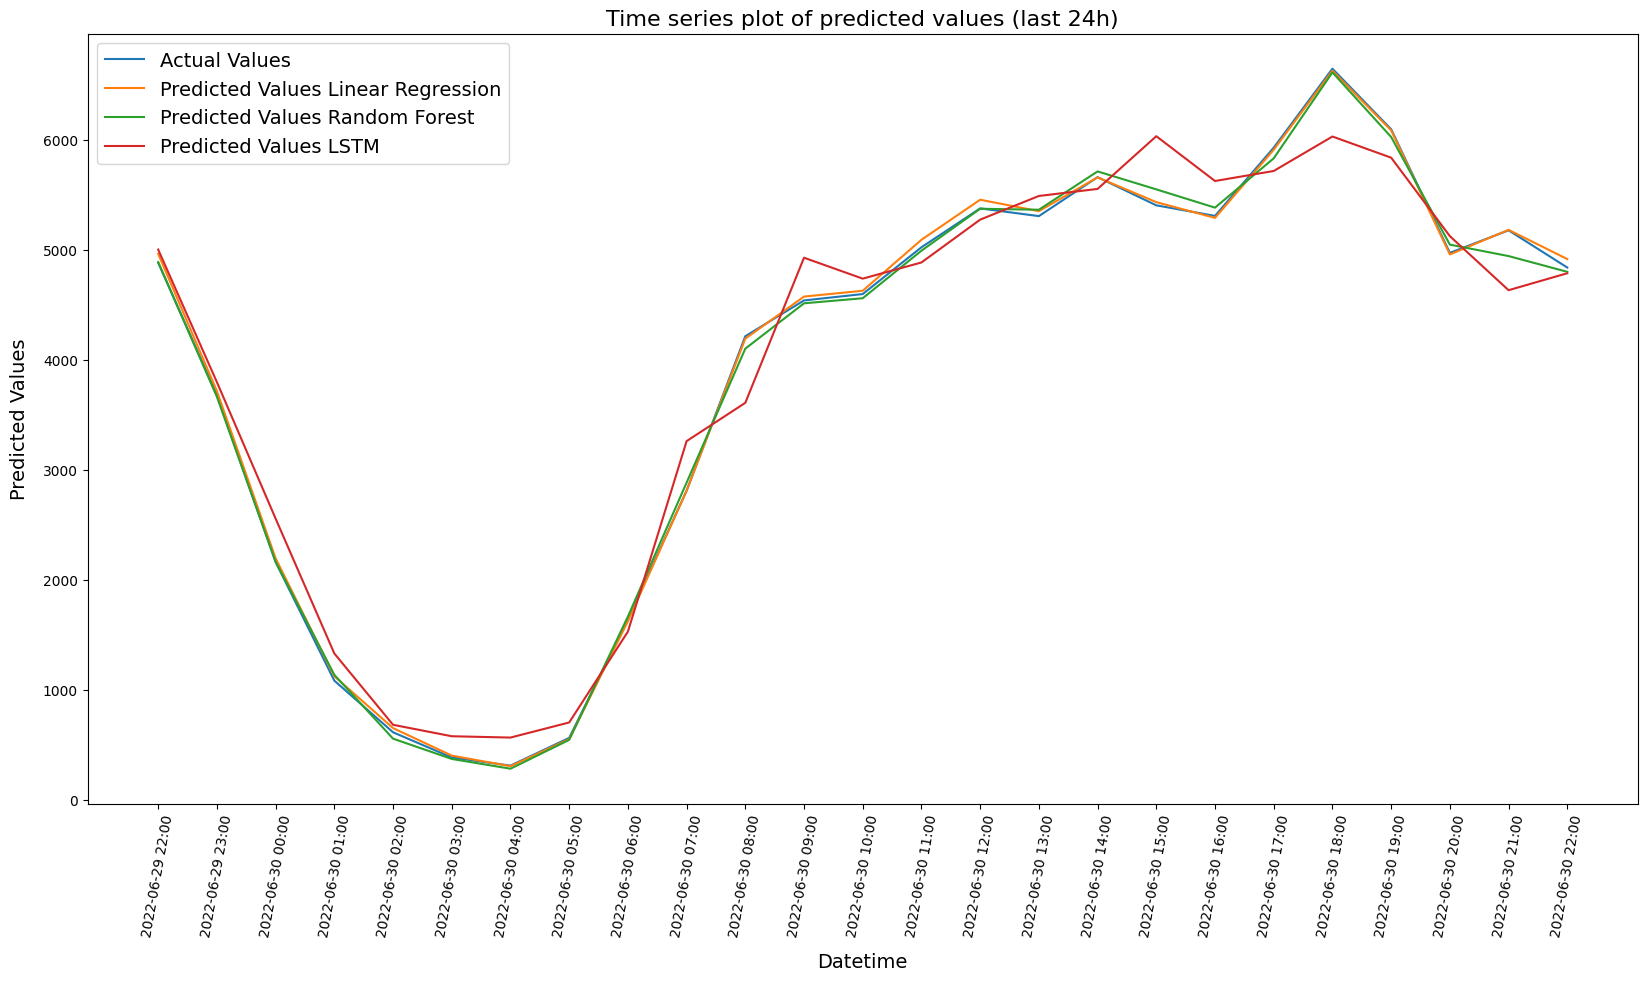

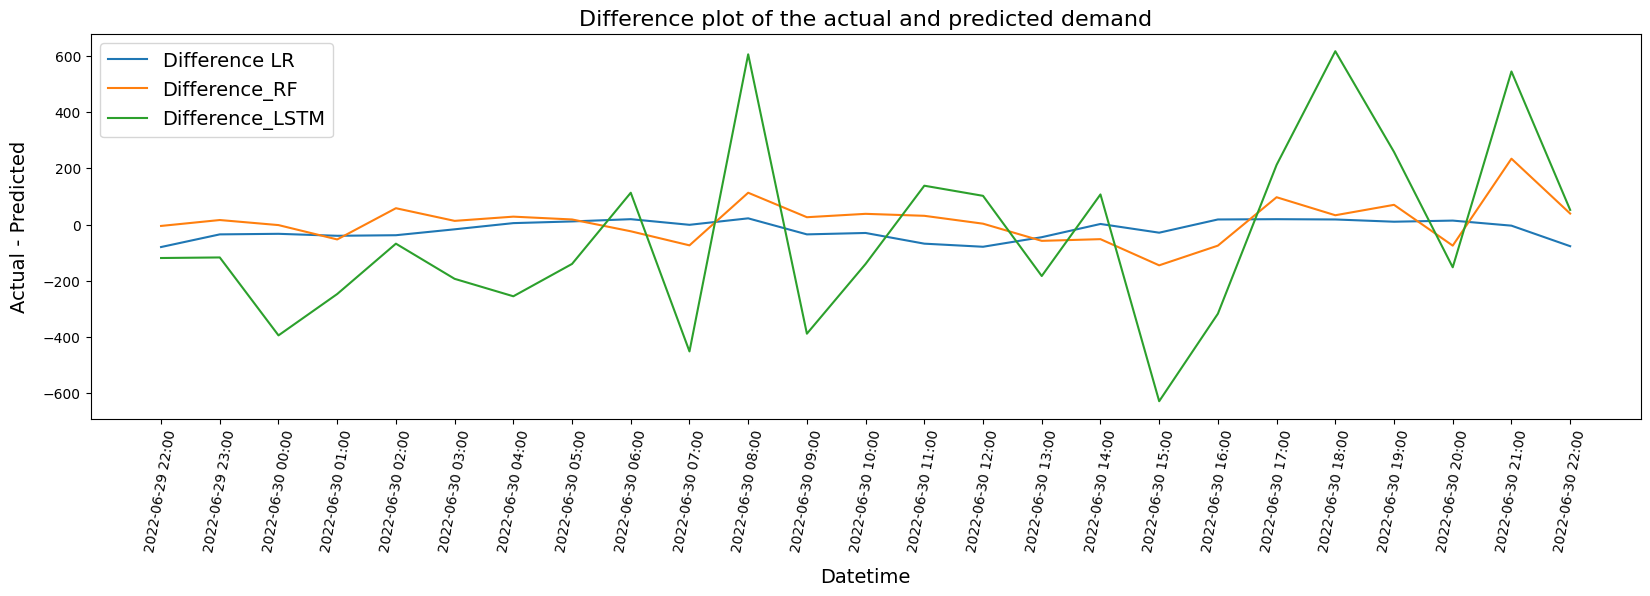

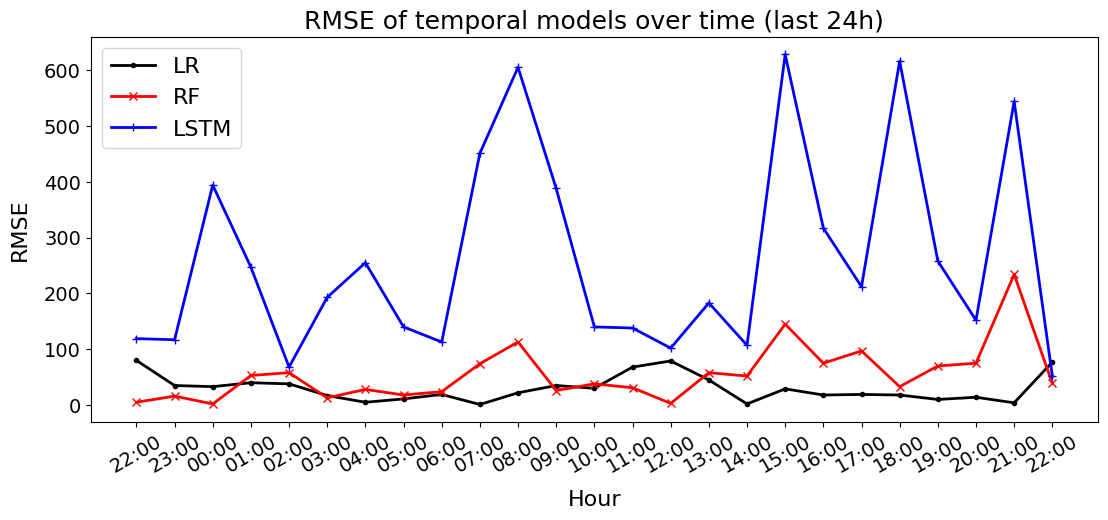

In [50]:
# Time series plot of the actual versus predicted values on the last 24 hours of the test set 
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(results_24h_all_models.index, results_24h_all_models['Actual'], label='Actual Values')
ax.plot(results_24h_all_models.index, results_24h_all_models['Predicted_LR'], label='Predicted Values Linear Regression')
ax.plot(results_24h_all_models.index, results_24h_all_models['Predicted_RF'], label='Predicted Values Random Forest')
ax.plot(results_24h_all_models.index, results_24h_all_models['Predicted_LSTM'], label='Predicted Values LSTM')
ax.set_xlabel('Datetime', fontsize = 14, labelpad = 10)
ax.set_ylabel('Predicted Values', fontsize = 14, labelpad = 10)
ax.set_title('Time series plot of predicted values (last 24h)', fontsize = 16)
plt.xticks(rotation=80)
ax.set_xticks(results_24h_all_models.index)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.legend(fontsize = 14)
plt.show()

# Difference plot of actual versus predicted values on the last 24 hours of the test set
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(results_24h_all_models.index, results_24h_all_models['Difference_LR'], label = 'Difference LR')
ax.plot(results_24h_all_models.index, results_24h_all_models['Difference_RF'], label = 'Difference_RF')
ax.plot(results_24h_all_models.index, results_24h_all_models['Difference_LSTM'], label = 'Difference_LSTM')
ax.set_xlabel('Datetime', fontsize = 14, labelpad = 10)
plt.xticks(rotation= 80)
ax.set_xticks(results_24h_all_models.index)
ax.set_ylabel('Actual - Predicted', fontsize = 14, labelpad = 10)
ax.set_title('Difference plot of the actual and predicted demand', fontsize = 16)
ax.legend(fontsize = 14)
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
plt.show()

# Comparison plot of the RMSE of the temporal models on the last 24 hours of the test set 
# Calculate the squared error for each datetime
results_24h_all_models['Squared_Error_LR'] = (results_24h_all_models['Actual'] - results_24h_all_models['Predicted_LR'])**2
results_24h_all_models['Squared_Error_RF'] = (results_24h_all_models['Actual'] - results_24h_all_models['Predicted_RF'])**2
results_24h_all_models['Squared_Error_LSTM'] = (results_24h_all_models['Actual'] - results_24h_all_models['Predicted_LSTM'])**2
# Take the square root of the mean squared error to get the RMSE
results_24h_all_models['RMSE_LR'] = np.sqrt(results_24h_all_models['Squared_Error_LR'])
results_24h_all_models['RMSE_RF'] = np.sqrt(results_24h_all_models['Squared_Error_RF'])
results_24h_all_models['RMSE_LSTM'] = np.sqrt(results_24h_all_models['Squared_Error_LSTM'])

# Plot the RMSE over time
fig, ax = plt.subplots(figsize=(13,5))
ax.plot(results_24h_all_models.index, results_24h_all_models['RMSE_LR'], label = 'LR',  marker='.', color = 'black', linewidth = 2)
ax.plot(results_24h_all_models.index, results_24h_all_models['RMSE_RF'], label = 'RF', marker = 'x', color = 'red', linewidth = 2)
ax.plot(results_24h_all_models.index, results_24h_all_models['RMSE_LSTM'], label = 'LSTM', marker = '+', color = 'blue', linewidth = 2)
ax.set_xlabel('Hour', fontsize = 16, labelpad = 10)
ax.set_ylabel('RMSE', fontsize = 16, labelpad = 10)
ax.set_title('RMSE of temporal models over time (last 24h)', fontsize = 18)
plt.xticks(rotation = 30, fontsize = 14)
plt.yticks(fontsize = 14)
ax.set_xticks(results_24h_all_models.index)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax.legend(fontsize = 16)
plt.savefig('RMSE_temporal.png', bbox_inches = 'tight')
plt.show()